In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm as tqdm
import requests
import os
import torchaudio.transforms as T
import torchaudio.functional as F
import torch
import torchaudio
import tarfile
from torchaudio.utils import download_asset
import librosa
import librosa.display
import scipy.io.wavfile
from scipy.fftpack import dct
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import scipy.io.wavfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Step 1: Download the file
url = "https://www.openslr.org/resources/12/train-clean-100.tar.gz"
file_name = "train-clean-100.tar.gz"
response = requests.get(url, stream=True)

In [3]:
with open(file_name, "wb") as f:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)

In [4]:
# Step 2: Extract the file
if file_name.endswith("tar.gz"):
    with tarfile.open(file_name, "r:gz") as tar:
        tar.extractall()
        tar.close()

In [5]:
# Step 3: Load the data (assuming the data consists of audio files and corresponding transcriptions)

# Define the directory where the extracted files are located
extracted_dir = "LibriSpeech/train-clean-100"

# Load the data (for demonstration purposes, we will just list some files)
audio_files = []
transcriptions = []

for root, dirs, files in os.walk(extracted_dir):
    for file in files:
        if file.endswith(".flac"):
            audio_files.append(os.path.join(root, file))
        elif file.endswith(".txt"):
            transcriptions.append(os.path.join(root, file))

In [6]:
# Print the first few audio files and transcriptions
print("First few audio files:", audio_files[:5])
print("First few transcription files:", transcriptions[:5])

First few audio files: ['LibriSpeech/train-clean-100/3879/174923/3879-174923-0044.flac', 'LibriSpeech/train-clean-100/3879/174923/3879-174923-0016.flac', 'LibriSpeech/train-clean-100/3879/174923/3879-174923-0040.flac', 'LibriSpeech/train-clean-100/3879/174923/3879-174923-0042.flac', 'LibriSpeech/train-clean-100/3879/174923/3879-174923-0004.flac']
First few transcription files: ['LibriSpeech/train-clean-100/3879/174923/3879-174923.trans.txt', 'LibriSpeech/train-clean-100/3879/173592/3879-173592.trans.txt', 'LibriSpeech/train-clean-100/7113/86041/7113-86041.trans.txt', 'LibriSpeech/train-clean-100/4813/248641/4813-248641.trans.txt', 'LibriSpeech/train-clean-100/4813/248638/4813-248638.trans.txt']


In [7]:
# Step 4: Example of loading an audio file (using torchaudio)
# Load the first audio file as an example
if audio_files:
    waveform, sample_rate = torchaudio.load(audio_files[1])
    print("Waveform shape:", waveform.shape)
    print("Sample rate:", sample_rate)

# Now you can process the waveform and sample_rate as needed for your machine learning algorithm

Waveform shape: torch.Size([1, 165360])
Sample rate: 16000


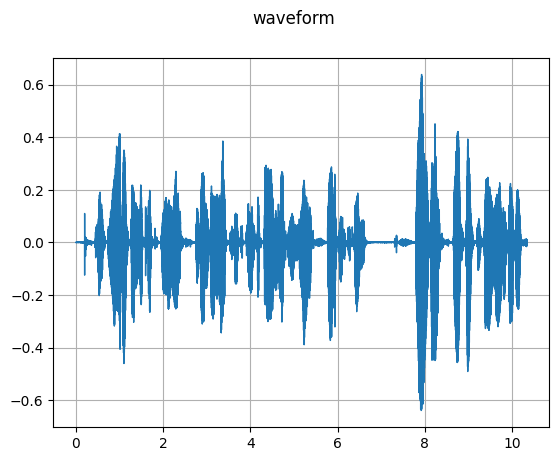

In [8]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

plot_waveform(waveform, sample_rate)

In [9]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

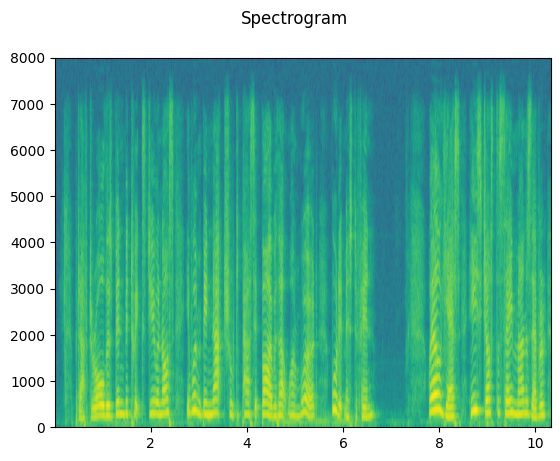

In [10]:
plot_specgram(waveform, sample_rate)

In [11]:
Audio(waveform.numpy()[0], rate = sample_rate)

In [12]:
sample_rate,waveform

(16000,
 tensor([[-1.2207e-04, -1.2207e-04, -9.1553e-05,  ..., -2.3193e-03,
          -3.2654e-03, -3.6316e-03]]))

In [13]:
# Fucntion for waveform, spectrogram and filterbanks

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)
        
        
        
# Function for spectrogram
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    
# Fucntion for filter-banks
def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1,1)
    axs.set_title(title or "Filter Bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [14]:
from matplotlib.patches import Rectangle

In [15]:
# Define transform
spectrogram = T.Spectrogram(n_fft = 512)
#
# performing Transform
spec =spectrogram(waveform)

In [16]:
# plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax = None)

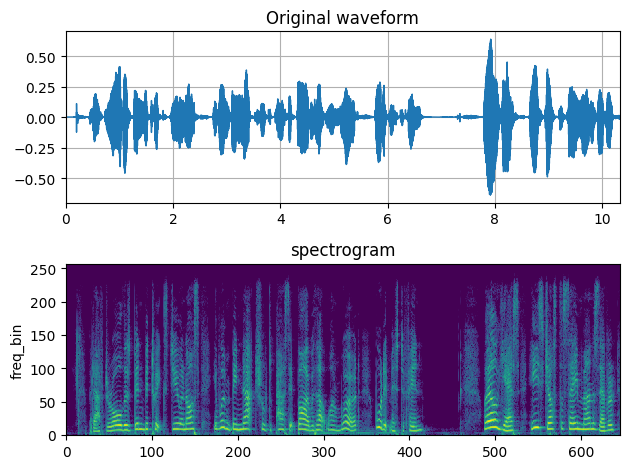

In [17]:
fig, axs = plt.subplots(2,1)
plot_waveform(waveform, sample_rate, title="Original waveform", ax = axs[0])
plot_spectrogram(spec[0],title="spectrogram", ax=axs[1])
fig.tight_layout()

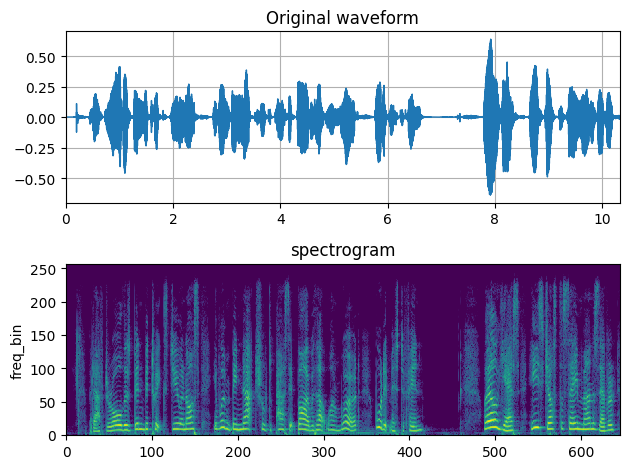

In [18]:
fig, axs = plt.subplots(2,1)
plot_waveform(waveform, sample_rate, title="Original waveform", ax = axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax =axs[1])
fig.tight_layout()
plt.show()

In [19]:
Audio(waveform.numpy(), rate=sample_rate)

### Fast Fourier Transform

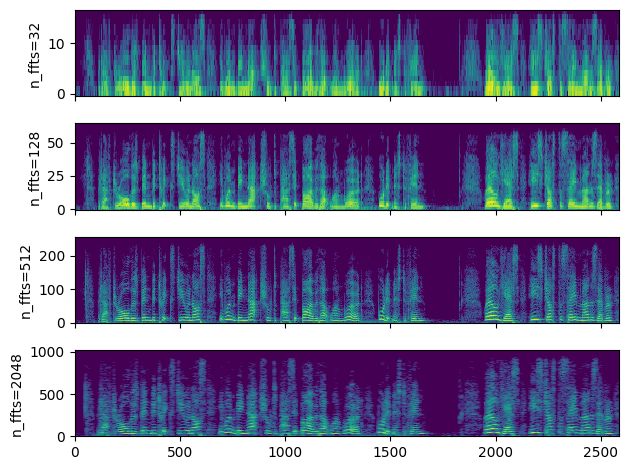

In [20]:
# Performing FFT
n_ffts = [32, 128, 512, 2048]
hop_length = 64

specs = []
for n_fft in n_ffts:
    spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec = spectrogram(waveform)
    specs.append(spec)
    
fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_ffts={n_fft}", ax= axs[i])
fig.tight_layout()

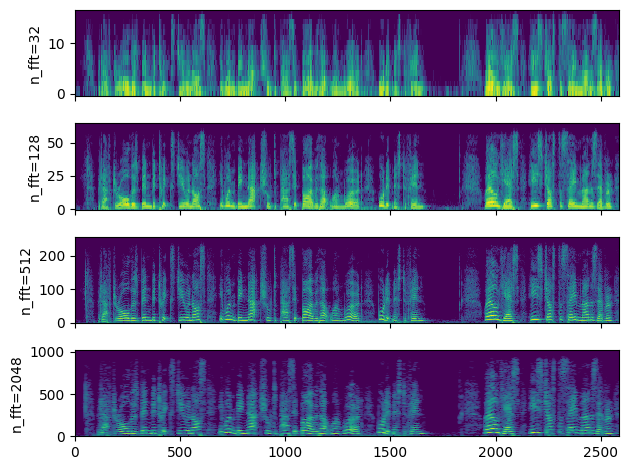

In [21]:
fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax = axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()

### Pre-emphasis

In [22]:
# Amplifying the high frequencies.
#  from the signal y(t) - ax(t-1)
pre_emphasis = 0.97

# Emphasize signal
emphasized_signal = np.append(waveform[0], waveform[1:] - pre_emphasis * waveform[:-1])